In [105]:
import cv2 as cv
import pykitti
import numpy as np
import matplotlib.pyplot as plt

Load the dataset

In [106]:
basedir = './dataset'
date = '2011_09_26'
drive = '0093'
dataset = pykitti.raw(basedir, date, drive)

Sample the first stereo grayscale image set

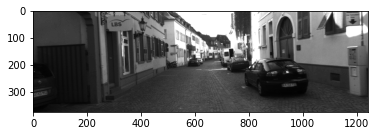

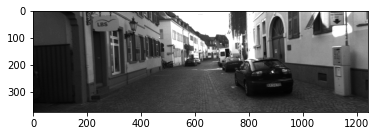

In [107]:
first_gray = dataset.get_gray(0)
plt.figure()
plt.imshow(first_gray[0], cmap='gray')
plt.figure()
plt.imshow(first_gray[1], cmap='gray')

Create the Feature Detector using the OpenCV FAST Detector

In [108]:
def featureDetector(img):
    fast = cv.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
    kp = fast.detect(img, None)
    img2 = cv.drawKeypoints(img, kp, None, color=(255, 0, 0))
    return kp, img2

Test the detector on the first dataset image

Number of features:  2356


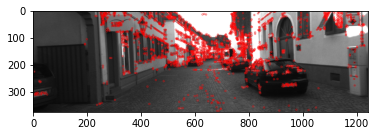

In [109]:
kp, img = featureDetector(np.array(first_gray[0]))
print("Number of features: ", len(kp))
plt.figure()
plt.imshow(img)

Utility function for converting Keypoint objects to tuples accepted by the feature tracker

In [110]:
def convertKeypointsToPoints(kp):
    points = []
    for i in range(len(kp)):
        points.append((kp[i].pt[0], kp[i].pt[1]))
    return np.array(points).astype(np.float32).reshape(-1, 1, 2)

Implement the Feature Tracker, using Lucas-Kanade Optical Flow

In [111]:
def featureTracker(img0, img1, kp0):
    lk_params = dict( winSize  = (21, 21),
                  maxLevel = 3,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 30, 0.01),
                  flags = 0,
                  minEigThreshold = 1e-4)
    kp1, st, err = cv.calcOpticalFlowPyrLK(img0, img1, kp0, None, **lk_params)

    # get good points
    if kp1 is not None:
        good_new = kp1[st==1]
        good_old = kp0[st==1]
    
    return good_new, good_old

Test the KLT Tracker on first 2 images

In [112]:
second_gray = dataset.get_gray(1)
gn, go = featureTracker(np.array(first_gray[0]), np.array(second_gray[0]), convertKeypointsToPoints(kp))
print(gn.shape, go.shape)

(2194, 2) (2194, 2)


Find Essential Matrix from the tracked keypoints

In [141]:
def poseRecovery(kp0, kp1, focal, pp):
    Es, mask1 = cv.findEssentialMat(kp1, kp0, focal, pp, method=cv.RANSAC, prob=0.999, threshold=1.0)
    cammax = np.delete(dataset.calib.P_rect_00, 3, 1)
    _, Ri, t, mask2 = cv.recoverPose(Es, kp1, kp0, cammax)
    return Ri, t, mask2

In [114]:
def updateTrajectory(R0, t0, R1, t1, scale):
    t0 = t0 + scale * t1 * R0
    R0 = np.dot(R0, R1)
    return R0, t0

In [115]:
def getAbsoluteScale(projection):
     pass
    #TODO: implement

In [136]:
print(np.delete(dataset.calib.P_rect_00, 3, 1))

[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]


In [117]:
def getFocalAndPrincipalPoint(projection):
    f = projection[0][0]
    pp = (projection[0][2], projection[1][2])
    return f, pp

In [118]:
def fetchImg(idx):
    img = dataset.get_gray(idx)[0]
    return img

In [148]:
img0 = fetchImg(0)
img1 = fetchImg(1)

kp0, _ = featureDetector(np.array(img0))
kp1, kp0 = featureTracker(np.array(img0), np.array(img1), convertKeypointsToPoints(kp0))

focal, pp = getFocalAndPrincipalPoint(dataset.calib.P_rect_00)

R1, t1, mask = poseRecovery(kp0, kp1, focal, pp)
R, t = R1, t1

MIN_FEATURES = 2000
trajectory = []
for i in range(len(dataset.cam0_files)):
    img0, kp0 = img1, kp1
    img1 = fetchImg(i)
    kp1, kp0 = featureTracker(np.array(img0), np.array(img1), kp0)
    
    R1, t1, mask = poseRecovery(kp0, kp1, focal, pp)
    #TODO: Add heuristic for scale and ensuring that the scale is not too small, and translation is always forwards
    R, t = updateTrajectory(R, t, R1, t1, 1)
    trajectory.append((R, t))

    # Replenish the feature points if we have too few
    if len(kp1) < MIN_FEATURES:
        kp1 = featureDetector(np.array(img1))

    # Plot the trajectory
    cv.imshow('img', np.array(img1))
    cv.waitKey(1)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1